In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

train_file_path = '/content/drive/My Drive/insurance_train.csv'
test_file_path = '/content/drive/My Drive/insurance_test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Подготовка данных

--- 1.1. Идентификация типов данных и пропусков ---
Обнаружены числовые признаки: ['age', 'bmi', 'children']
Обнаружены категориальные признаки: ['sex', 'smoker', 'region']

Пропуски в 'df_train' не найдены.
--------------------------------------------------

--- 1.2. Анализ и фильтрация выбросов ---
Визуализация распределений (до фильтрации):


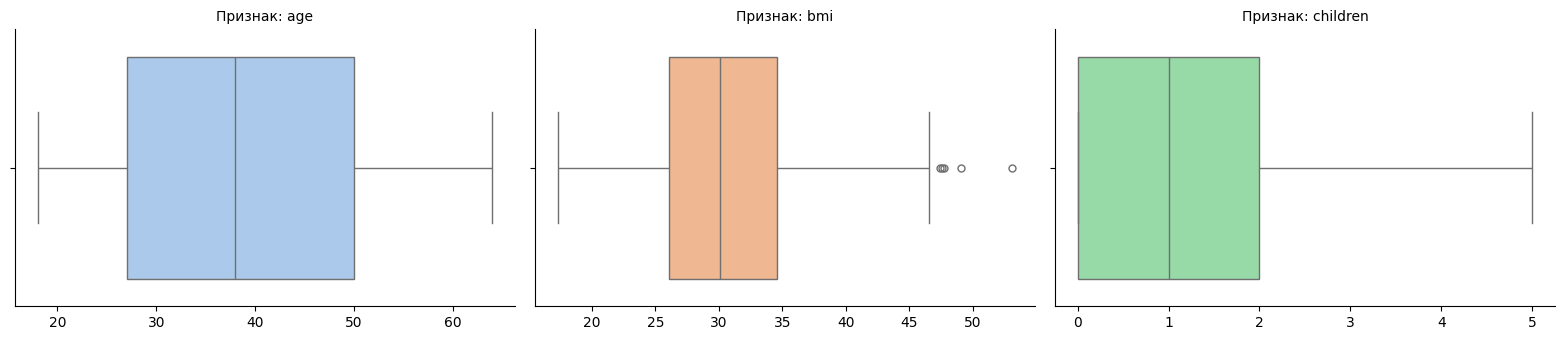

Исходный размер данных: (338, 7)
Размер после фильтрации: (333, 7)
Удалено строк: 5
--------------------------------------------------

--- 1.3. Преобразование категориальных признаков ---
Размер 'df_train' после OHE: (333, 9)
Размер 'df_test' после OHE: (1000, 9)
Удаление лишних колонок из 'df_test': ['charges']
Колонки 'df_train' и 'df_test' успешно синхронизированы.
--------------------------------------------------

--- 1.4. Корреляционный анализ ---


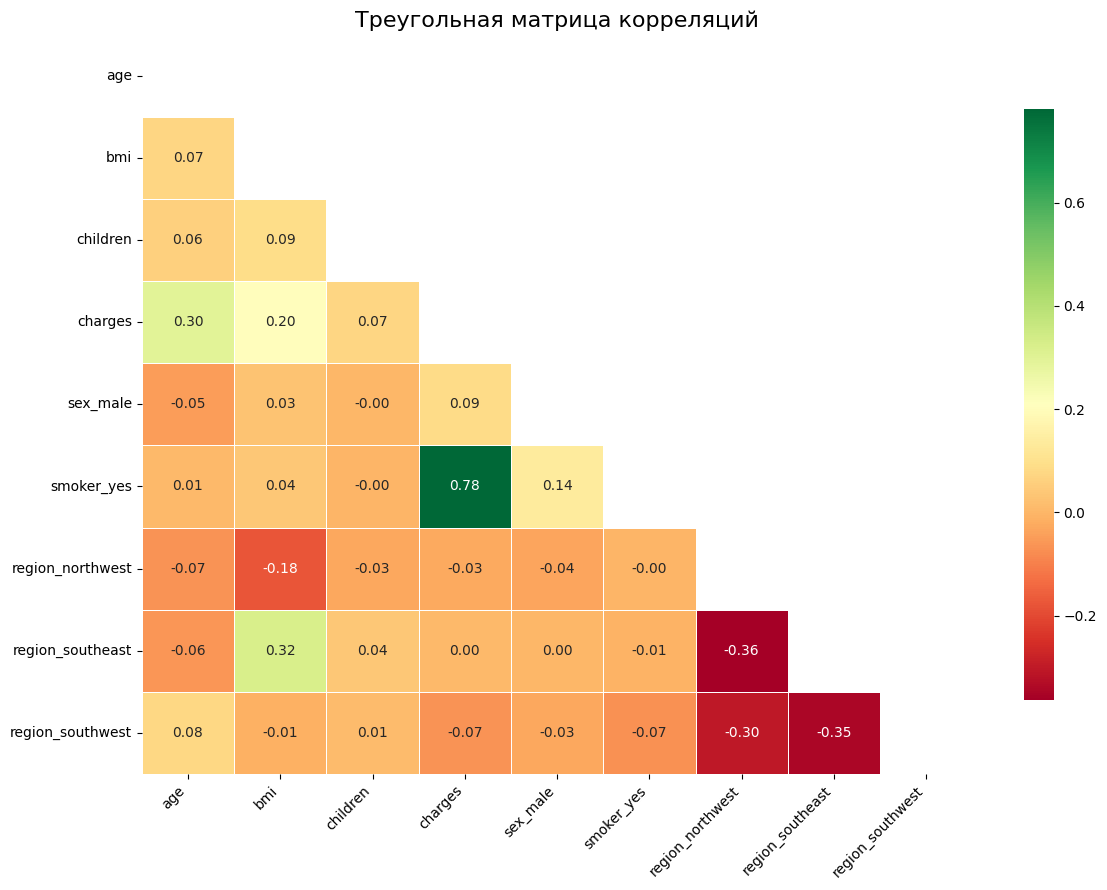

In [24]:
try:
    df_train = pd.read_csv(train_file_path)
    df_test = pd.read_csv(test_file_path)
except FileNotFoundError:
    print("Ошибка: Убедитесь, что файлы 'insurance_train.csv' и 'insurance_test.csv' находятся в корне вашего Google Drive.")
    raise

TARGET_VARIABLE = 'charges'

print("--- 1.1. Идентификация типов данных и пропусков ---")

numeric_features = [
    col for col in df_train.columns
    if pd.api.types.is_numeric_dtype(df_train[col]) and col != TARGET_VARIABLE
]
categorical_features = [
    col for col in df_train.columns
    if pd.api.types.is_object_dtype(df_train[col]) or isinstance(df_train[col].dtype, pd.CategoricalDtype)
]

print(f"Обнаружены числовые признаки: {numeric_features}")
print(f"Обнаружены категориальные признаки: {categorical_features}")

missing_data = df_train.isna().sum()
missing_data = missing_data.loc[lambda x: x > 0]

if missing_data.empty:
    print("\nПропуски в 'df_train' не найдены.")
else:
    print("\nОбнаружены пропуски в 'df_train':")
    print(missing_data)

print("-" * 50)

print("\n--- 1.2. Анализ и фильтрация выбросов ---")

df_melted = df_train.melt(value_vars=numeric_features)

print("Визуализация распределений (до фильтрации):")
g = sns.catplot(
    data=df_melted,
    x='value',
    col='variable',
    hue='variable',
    legend=False,
    kind='box',
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=3.5,
    aspect=1.5,
    palette='pastel'
)
g.set_titles("Признак: {col_name}")
g.set_xlabels("")
plt.tight_layout()
plt.show()

class IQRCleaner:
    def __init__(self, factor=1.5):
        self.factor = factor

    def transform(self, data, columns):
        df_processed = data.copy()
        print(f"Исходный размер данных: {df_processed.shape}")

        for col in columns:
            Q1 = df_processed[col].quantile(0.25)
            Q3 = df_processed[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_threshold = Q1 - self.factor * IQR
            upper_threshold = Q3 + self.factor * IQR

            df_processed = df_processed[
                (df_processed[col] >= lower_threshold) &
                (df_processed[col] <= upper_threshold)
            ]

        print(f"Размер после фильтрации: {df_processed.shape}")
        print(f"Удалено строк: {data.shape[0] - df_processed.shape[0]}")
        return df_processed

cleaner = IQRCleaner(factor=1.5)
df_train_processed = cleaner.transform(df_train, numeric_features)

print("-" * 50)

print("\n--- 1.3. Преобразование категориальных признаков ---")

df_train_final = pd.get_dummies(df_train_processed, columns=categorical_features, drop_first=True)
df_test_final = pd.get_dummies(df_test, columns=categorical_features, drop_first=True)

print(f"Размер 'df_train' после OHE: {df_train_final.shape}")
print(f"Размер 'df_test' после OHE: {df_test_final.shape}")

train_cols = set(df_train_final.drop(columns=[TARGET_VARIABLE]).columns)
test_cols = set(df_test_final.columns)

cols_to_add = train_cols - test_cols
if cols_to_add:
    print(f"Добавление недостающих колонок в 'df_test': {list(cols_to_add)}")
    for col in cols_to_add:
        df_test_final[col] = 0

cols_to_drop = test_cols - train_cols
if cols_to_drop:
    print(f"Удаление лишних колонок из 'df_test': {list(cols_to_drop)}")
    df_test_final = df_test_final.drop(columns=list(cols_to_drop))

df_test_final = df_test_final[df_train_final.drop(columns=[TARGET_VARIABLE]).columns]

print("Колонки 'df_train' и 'df_test' успешно синхронизированы.")
print("-" * 50)

print("\n--- 1.4. Корреляционный анализ ---")

corr_matrix = df_train_final.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='RdYlGn',
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)
plt.title("Треугольная матрица корреляций", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 2. Многомерная линейная регрессия

In [25]:
import numpy as np
import pandas as pd

TARGET_COLUMN = 'charges'

print("--- 2.1. Подготовка матриц (X, y) ---")

X_train_data = df_train_final.drop(TARGET_COLUMN, axis=1).to_numpy(dtype=np.float64)
y_train_data = df_train_final[TARGET_COLUMN].to_numpy(dtype=np.float64)
X_test_data = df_test_final.to_numpy(dtype=np.float64)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_data)
X_test_scaled = scaler.transform(X_test_data)

m_train = X_train_scaled.shape[0]
bias_feature = np.ones((m_train, 1), dtype=np.float64)
X_train_b = np.hstack([bias_feature, X_train_scaled])

y_train_v = y_train_data.reshape(-1, 1)

print(f"Размер матрицы признаков X (train): {X_train_b.shape}")
print(f"Размер вектора y (train): {y_train_v.shape}")
print("-" * 50)

print("\n--- 2.2. Аналитическое решение ---")

def solve_normal_equation(X, y):
    try:
        A = X.T.dot(X)
        b = X.T.dot(y)

        weights = np.linalg.solve(A, b)
        return weights

    except np.linalg.LinAlgError:
        print("Ошибка: Матрица (XᵀX) вырожденная. Используется псевдообратная.")
        weights = np.linalg.pinv(X).dot(y)
        return weights

w_analytic = solve_normal_equation(X_train_b, y_train_v)
print("Аналитическое решение найдено.")
print("-" * 50)

print("\n--- 2.3. Численное решение (Градиентный спуск) ---")

class LinearRegressorGD:
    def __init__(self, eta=0.01, n_iterations=1000, random_seed=42):
        self.eta = eta
        self.n_iterations = n_iterations
        self.random_seed = random_seed
        self.weights_ = None
        self.cost_history_ = []

    def _calculate_cost(self, X, y_true):
        m = X.shape[0]
        y_pred = X.dot(self.weights_)
        cost = (1/m) * np.sum((y_pred - y_true)**2)
        return cost

    def fit(self, X, y):
        m_samples, n_features = X.shape

        rgen = np.random.RandomState(self.random_seed)
        self.weights_ = rgen.normal(loc=0.0, scale=0.01, size=(n_features, 1))
        self.cost_history_ = []

        for i in range(self.n_iterations):
            predictions = X.dot(self.weights_)

            errors = predictions - y

            gradients = (2 / m_samples) * X.T.dot(errors)

            self.weights_ = self.weights_ - self.eta * gradients

            if i % 1000 == 0:
                cost = self._calculate_cost(X, y)
                self.cost_history_.append(cost)

        print(f"Градиентный спуск завершен. Итераций: {self.n_iterations}.")
        return self

LEARNING_RATE = 0.001
EPOCHS = 10000

gd_regressor = LinearRegressorGD(eta=LEARNING_RATE, n_iterations=EPOCHS)
gd_regressor.fit(X_train_b, y_train_v)
w_numerical = gd_regressor.weights_


print("\n--- 2.4. Сравнение весов ---")

feature_names = ['intercept'] + df_train_final.drop(TARGET_COLUMN, axis=1).columns.tolist()

results_df = pd.DataFrame({
    'Feature': feature_names,
    'W_Analytic': w_analytic.flatten(),
    'W_Numerical (GD)': w_numerical.flatten()
})

results_df['W_Analytic'] = results_df['W_Analytic'].map('{:,.4f}'.format)
results_df['W_Numerical (GD)'] = results_df['W_Numerical (GD)'].map('{:,.4f}'.format)

print(results_df.to_string(index=False))

--- 2.1. Подготовка матриц (X, y) ---
Размер матрицы признаков X (train): (333, 9)
Размер вектора y (train): (333, 1)
--------------------------------------------------

--- 2.2. Аналитическое решение ---
Аналитическое решение найдено.
--------------------------------------------------

--- 2.3. Численное решение (Градиентный спуск) ---
Градиентный спуск завершен. Итераций: 10000.

--- 2.4. Сравнение весов ---
         Feature  W_Analytic W_Numerical (GD)
       intercept 13,907.5366      13,907.5366
             age  3,444.2412       3,444.2890
             bmi  2,044.5514       2,044.4342
        children    588.1792         588.1749
        sex_male   -133.5670        -133.5320
      smoker_yes  9,582.8996       9,582.9453
region_northwest    -90.9762         -90.5844
region_southeast   -629.9373        -629.4740
region_southwest   -658.2360        -657.8357


## 3. Добавление регуляризации

In [26]:
y_test_data = df_test[TARGET_COLUMN].to_numpy(dtype=np.float64).reshape(-1, 1)

m_test = X_test_scaled.shape[0]
bias_test = np.ones((m_test, 1), dtype=np.float64)
X_test_b = np.hstack([bias_test, X_test_scaled])

print(f"Размер матрицы признаков X (test): {X_test_b.shape}")
print(f"Размер вектора y (test): {y_test_data.shape}")
print("-" * 50)


def solve_ridge_analytic(X, y, lambda_):
    n_features = X.shape[1]

    A = X.T.dot(X)

    I_star = np.eye(n_features)
    I_star[0, 0] = 0.0

    A = A + lambda_ * I_star

    b = X.T.dot(y)

    try:
        weights = np.linalg.solve(A, b)
        return weights
    except np.linalg.LinAlgError:
        print(f"Ошибка: Матрица вырождена для lambda={lambda_}.")
        return np.linalg.pinv(A).dot(b)

print("Аналитическая функция Ridge определена.")
print("-" * 50)

class RidgeRegressorGD:
    def __init__(self, eta=0.01, n_iterations=1000, lambda_=0.1, random_seed=42):
        self.eta = eta
        self.n_iterations = n_iterations
        self.lambda_ = lambda_
        self.random_seed = random_seed
        self.weights_ = None
        self.cost_history_ = []

    def fit(self, X, y):
        m_samples, n_features = X.shape

        rgen = np.random.RandomState(self.random_seed)
        self.weights_ = rgen.normal(loc=0.0, scale=0.01, size=(n_features, 1))

        for _ in range(self.n_iterations):
            predictions = X.dot(self.weights_)
            errors = predictions - y

            mse_gradient = (2 / m_samples) * X.T.dot(errors)

            reg_gradient = (2 * self.lambda_ / m_samples) * self.weights_

            reg_gradient[0] = 0

            total_gradient = mse_gradient + reg_gradient

            self.weights_ = self.weights_ - self.eta * total_gradient

        return self

print("Класс RidgeRegressorGD определен.")
print("-" * 50)

def compute_mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def compute_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(compute_mean_squared_error(y_true, y_pred))

LEARNING_RATE = 0.001
EPOCHS = 10000

alphas = [0.0, 0.01, 0.1, 1, 10, 100, 1000]
tuning_results = []

print("--- 3.3. Подбор параметра регуляризации (lambda) ---")

for lambda_val in alphas:
    w_ridge_an = solve_ridge_analytic(X_train_b, y_train_v, lambda_val)
    y_pred_an = X_test_b.dot(w_ridge_an)
    mse_an = compute_mean_squared_error(y_test_data, y_pred_an)

    ridge_gd = RidgeRegressorGD(
        eta=LEARNING_RATE,
        n_iterations=EPOCHS,
        lambda_=lambda_val
    )
    ridge_gd.fit(X_train_b, y_train_v)
    y_pred_gd = X_test_b.dot(ridge_gd.weights_)
    mse_gd = compute_mean_squared_error(y_test_data, y_pred_gd)

    tuning_results.append({
        'Lambda': lambda_val,
        'MSE_Analytic': mse_an,
        'MSE_GD': mse_gd,
        'RMSE_Analytic': np.sqrt(mse_an),
        'RMSE_GD': np.sqrt(mse_gd)
    })

tuning_df = pd.DataFrame(tuning_results)
print(tuning_df.to_string(float_format="%.2f", index=False))
print("-" * 50)

Размер матрицы признаков X (test): (1000, 9)
Размер вектора y (test): (1000, 1)
--------------------------------------------------
Аналитическая функция Ridge определена.
--------------------------------------------------
Класс RidgeRegressorGD определен.
--------------------------------------------------
--- 3.3. Подбор параметра регуляризации (lambda) ---
 Lambda  MSE_Analytic      MSE_GD  RMSE_Analytic  RMSE_GD
   0.00   34288624.16 34288425.80        5855.65  5855.63
   0.01   34288867.68 34288669.45        5855.67  5855.65
   0.10   34291066.50 34290869.42        5855.86  5855.84
   1.00   34313756.01 34313570.14        5857.79  5857.78
  10.00   34606501.14 34606397.04        5882.73  5882.72
 100.00   41261499.24 41261498.83        6423.51  6423.51
1000.00   95011833.08 95011833.04        9747.40  9747.40
--------------------------------------------------


## 4. Оценка обобщающей способности


--- 4. Оценка обобщающей способности ---

--- Итоговое сравнение моделей ---
                                 MSE     RMSE
Linear (GD)              34288425.80  5855.63
Ridge (GD, L=0.0)        34288425.80  5855.63
Ridge (Analytic, L=0.0)  34288624.16  5855.65
Linear (Analytic)        34288624.16  5855.65
Constant (Baseline)     141456566.89 11893.55

--- Визуализация сравнения моделей ---


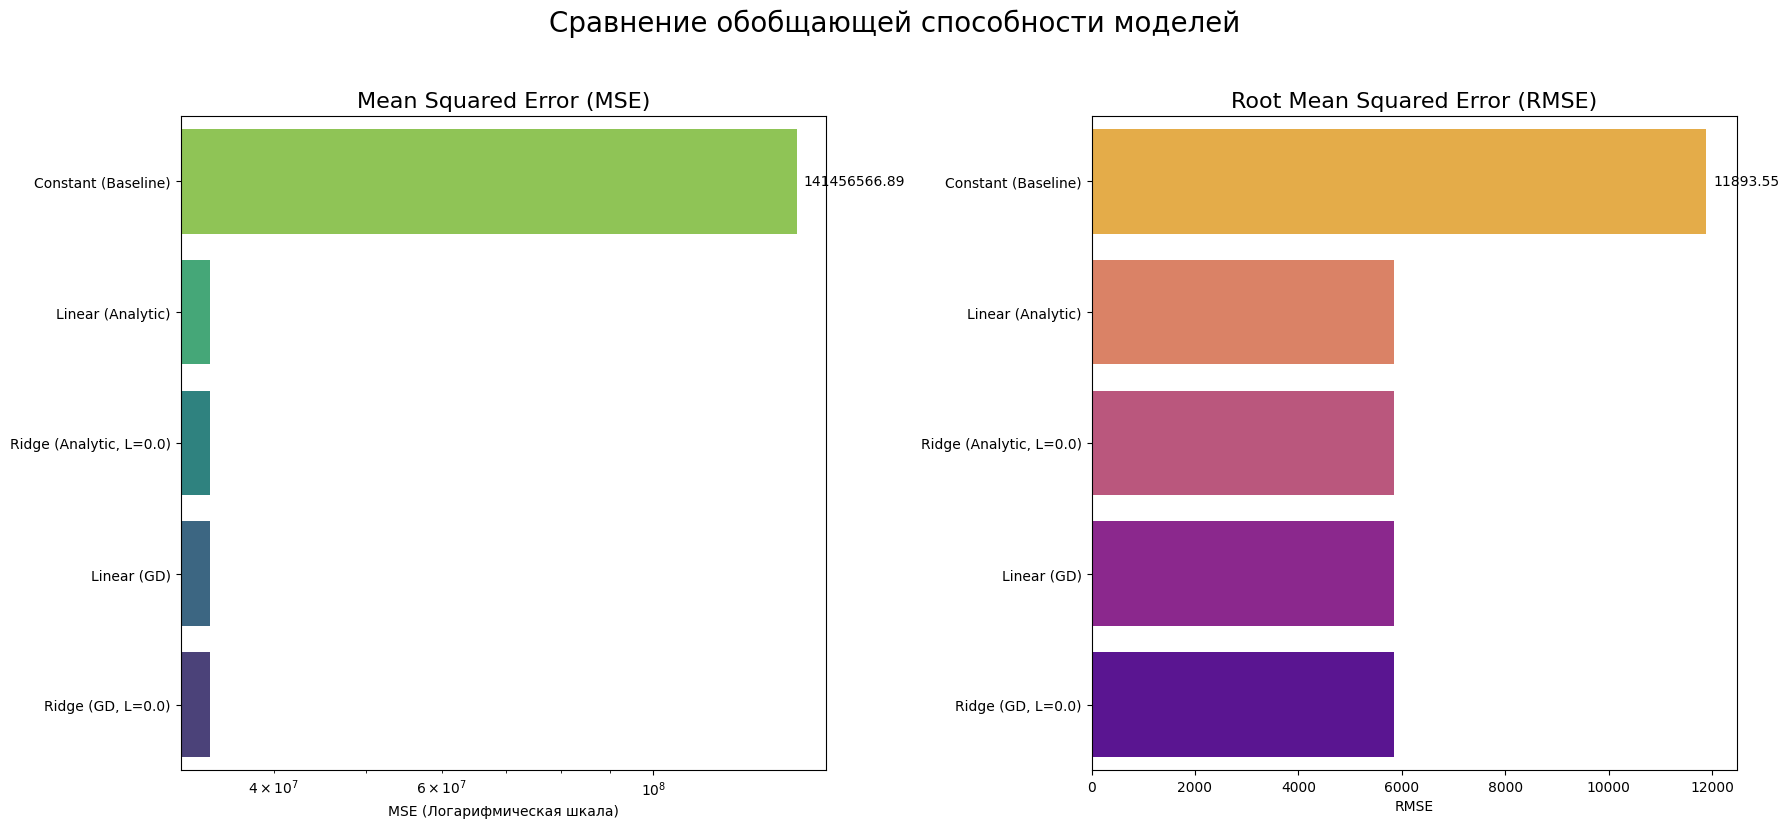

In [27]:
print("\n--- 4. Оценка обобщающей способности ---")

final_report = {}

y_pred_const = np.full_like(y_test_data, fill_value=y_train_v.mean())
final_report['Constant (Baseline)'] = {
    'MSE': compute_mean_squared_error(y_test_data, y_pred_const),
    'RMSE': compute_root_mean_squared_error(y_test_data, y_pred_const)
}

y_pred_linear_an = X_test_b.dot(w_analytic)
final_report['Linear (Analytic)'] = {
    'MSE': compute_mean_squared_error(y_test_data, y_pred_linear_an),
    'RMSE': compute_root_mean_squared_error(y_test_data, y_pred_linear_an)
}

y_pred_linear_gd = X_test_b.dot(w_numerical)
final_report['Linear (GD)'] = {
    'MSE': compute_mean_squared_error(y_test_data, y_pred_linear_gd),
    'RMSE': compute_root_mean_squared_error(y_test_data, y_pred_linear_gd)
}

best_lambda_an = tuning_df.loc[tuning_df['MSE_Analytic'].idxmin()]
best_lambda_gd = tuning_df.loc[tuning_df['MSE_GD'].idxmin()]

final_report[f'Ridge (Analytic, L={best_lambda_an["Lambda"]})'] = {
    'MSE': best_lambda_an['MSE_Analytic'],
    'RMSE': best_lambda_an['RMSE_Analytic']
}
final_report[f'Ridge (GD, L={best_lambda_gd["Lambda"]})'] = {
    'MSE': best_lambda_gd['MSE_GD'],
    'RMSE': best_lambda_gd['RMSE_GD']
}

report_df = pd.DataFrame.from_dict(final_report, orient='index').sort_values(by='RMSE')

print("\n--- Итоговое сравнение моделей ---")
print(report_df.to_string(float_format="%.2f"))

print("\n--- Визуализация сравнения моделей ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Сравнение обобщающей способности моделей', fontsize=20, y=1.03)

report_df_sorted = report_df.sort_values(by='RMSE', ascending=False)
y_labels = report_df_sorted.index

sns.barplot(
    x=report_df_sorted['MSE'],
    y=y_labels,
    hue=y_labels,
    ax=ax1,
    palette='viridis_r',
    legend=False
)
ax1.set_title('Mean Squared Error (MSE)', fontsize=16)
ax1.set_xlabel('MSE (Логарифмическая шкала)')
ax1.set_ylabel('')
ax1.set_xscale('log')
ax1.bar_label(ax1.containers[0], fmt='%.2f', padding=5)

sns.barplot(
    x=report_df_sorted['RMSE'],
    y=y_labels,
    hue=y_labels,
    ax=ax2,
    palette='plasma_r',
    legend=False
)
ax2.set_title('Root Mean Squared Error (RMSE)', fontsize=16)
ax2.set_xlabel('RMSE')
ax2.set_ylabel('')
ax2.bar_label(ax2.containers[0], fmt='%.2f', padding=5)

plt.tight_layout()
plt.show()